# SST Climatology

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo.xr

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.climat import climatology



In [5]:
%run {_work_dir}utils/plot_tools.ipynb

# The Dataset

In [6]:
files = ! ls {_data_dir}/CMEMS/OSTIA/*.nc

In [7]:
big_sst_ds=xr.open_mfdataset(files)

In [8]:
big_sst_ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 1981-12-20T12:00:00
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    comment:                    WARNING Some applications are unable to prope...
    ...                         ...
    processing_level:           L4
    cdm_data_type:              grid
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    sensor:                     AMSR2, AMSRE, GOES<13,16>, SEVIRI, SLSTRA, AT...
    platform:                   GCOM-W, AQUA, GOES<13,16>, MetoSat<08,09,10,1...
    source:                     AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, G...

In [9]:
sst_daily_ds=big_sst_ds.where(big_sst_ds.lat<-40, drop=True)

# Measurements under the ice

There are significant areas in the MIZ / pack ice where ocean temperature has been set to a minimum (-1.8C) :

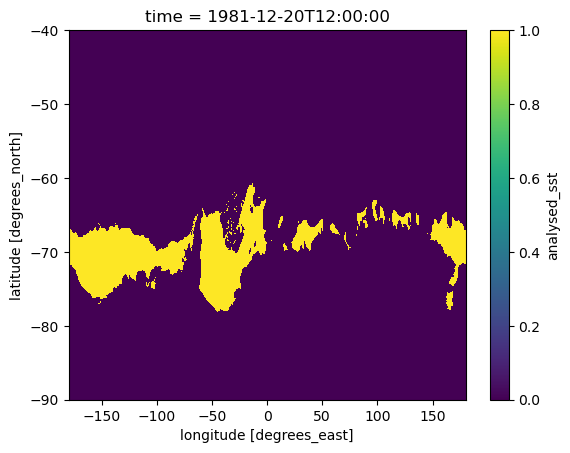

In [43]:
(sst_daily_da.sel(time='1981-12-20')==271.35).plot()

The produce includes an error field, this looks ok :

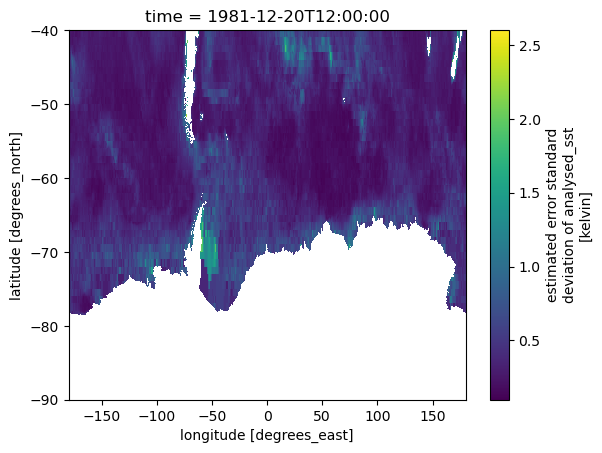

In [29]:
sst_daily_da.sel(time='1981-12-20').analysis_error.plot()

Comparing SST to the sea ice extent shows that some areas within the MIZ and in polynias are reporting 'real' SSTs, so it looks like these could be useful observations

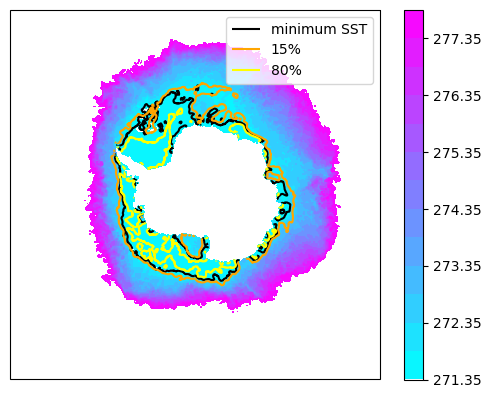

In [50]:
plt.figure()
plt.subplot(projection=ccrs.SouthPolarStereo())

to_plot = sst_daily_ds.sel(time='1981-12-20') ;

plt.contourf(
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).analysed_sst,
    levels=np.arange(271.35,278.2,0.5),
    cmap='cool',
    transform=ccrs.PlateCarree(),
    # vmin=271.35,
    # vmax=278.15
)

plt.colorbar()

cs=plt.contour(  
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).analysed_sst,
    [271.4],
    colors=['black'],
    transform=ccrs.PlateCarree(),
)
cs.collections[0].set_label('minimum SST')

cs=plt.contour(
    to_plot.lon, 
    to_plot.lat,
    to_plot.isel(time=0).sea_ice_fraction,
    [0.15,0.80],
    linestyles='solid',
    colors=['orange','yellow'],
    transform=ccrs.PlateCarree(),
)
cs.collections[0].set_label('15%')
cs.collections[1].set_label('80%')

plt.legend()

# Climatology

In [42]:
sst_daily_da=sst_daily_ds.analysed_sst

In [12]:
sst_monthly_da=sst_daily_da.resample(time="M").mean('time')

In [14]:
climat_sst_ds=climatology(sst_daily_da)

In [16]:
anoms_da=sst_monthly_da.groupby('time.month')-climat_sst_ds.ave

In [ ]:
for MONTH in np.arange(1,13,1):

    to_plot=climat_sst_ds.sel(month=MONTH).ave

    
    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())


    plt.pcolormesh(
        to_plot.lon, 
        to_plot.lat, 
        to_plot,
        transform=ccrs.PlateCarree(),
        vmin=273, vmax=278,
        shading='gouraud'
    )

    ax.coastlines()

    plt.colorbar(label='SST (K)')

    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -60], crs=ccrs.PlateCarree())

    add_south_pole_gridlines(ax)
    
    #plt.title(f'Chlor_a conc {months[MONTH-1]} average')
    
    plt.show()
    
    